# Brain Tumor Identification
By Jonathan Nunez

abstract

# Business Understanding

# Data Understanding

In [ ]:
# For Google Colab only
# Cell output cleared as it only contains installation progress
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install split-folders

In [ ]:
# Importing tools and modules for data preperation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img

import random
import splitfolders

In [ ]:
# Code to create kaggle path for data download
# Code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"",
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
# Downloading kaggle dataset
# Cell output cleared as only contains data download progress
!kaggle datasets download -d ishans24/brain-tumor-dataset

# Creating parent folder directory for data unzip
!mkdir /content/brain_tumor_dataset
!unzip brain-tumor-dataset.zip -d /content/brain_tumor_dataset

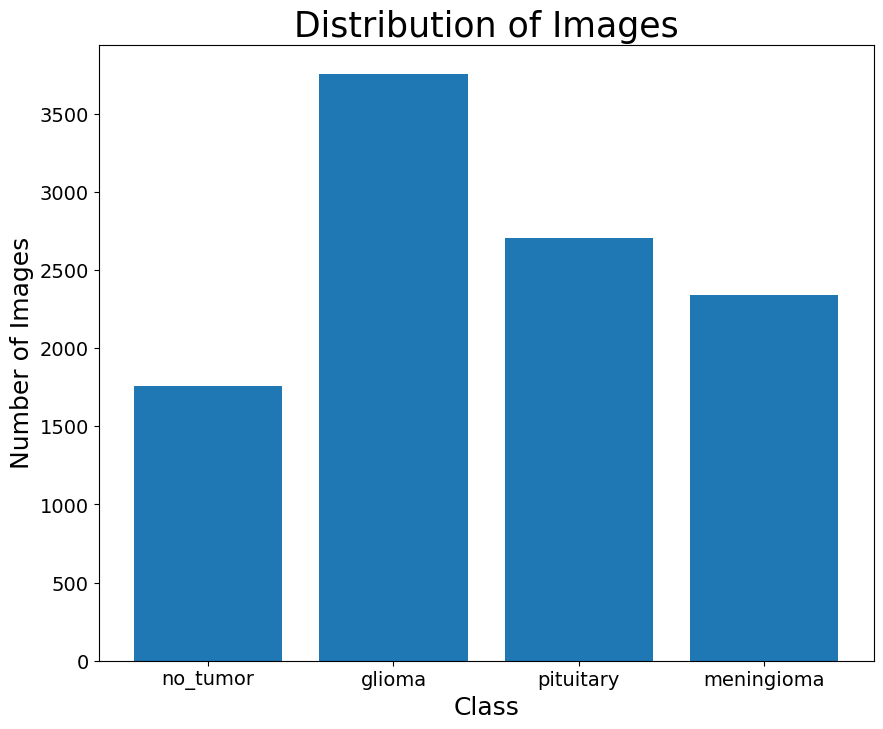

In [ ]:
# Count the number of images in each class
directory = 'brain_tumor_dataset'
classes = os.listdir(directory)

image_counts = {cls: len(os.listdir(os.path.join(directory, cls))) for cls in classes}
df = pd.Series(image_counts)

# Plotting the distribution of images
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(df.index, df)
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Data Distribution', fontsize=25)
ax.set_xlabel('Classes', fontsize=18)
ax.set_ylabel('Number of Images', fontsize=18);

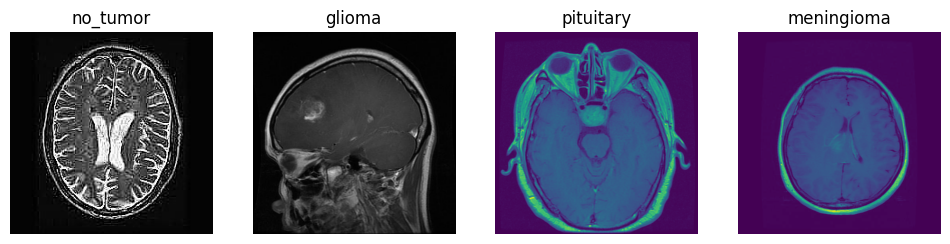

In [ ]:
# Code to randomly display an image from each class
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i, category in enumerate(['no_tumor', 'glioma', 'pituitary', 'meningioma']):
    path = os.path.join(directory, category)
    sample = random.choice(os.listdir(path))
    img = mpimg.imread(os.path.join(path, sample))

    axes[i].imshow(img)
    axes[i].set_title(f"{category}")
    axes[i].axis('off');

## Data preparation

In [ ]:
# Splitting data into train, test, and validation data directories
splitfolders.ratio('brain_tumor_dataset', output='b_tumor_data_split', seed=42, ratio=(.7, 0.15, 0.15))

Copying files: 10560 files [00:01, 6636.41 files/s]


In [ ]:
# Directory paths
train_dir = 'b_tumor_data_split/train'
test_dir = 'b_tumor_data_split/test'
val_dir = 'b_tumor_data_split/val'

In [ ]:
# Variable to rescale images as its being imported
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Importing brain tumor image data
train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(256, 256),
                                              batch_size=7390,
                                              seed=42
                                              )

test_generator = datagen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=1588,
                                             seed=42
                                             )

val_generator = datagen.flow_from_directory(val_dir,
                                            target_size=(256, 256),
                                            batch_size=1582,
                                            seed=42
                                            )

Found 7390 images belonging to 4 classes.
Found 1588 images belonging to 4 classes.
Found 1582 images belonging to 4 classes.


In [ ]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Modeling

For the model building, I imported tools from the Tensorflow library, primarily Keras tools.
From Tensorflows’s Keras I imported the models I would test and use such as DenseNet, and ResNet as well as the layer modules I’d use to help tune the model such as dense, and dropout layers to name a few.

Before choosing a final model I created 3 base models, a Convolutional Neural Network (CNN), DenseNet, and ResNet model. From these models I went with the DenseNet model to further fine tune as it showed the best results with the least number of layers. To help with the model tuning, I implemented an early stop callback to keep track of the model’s validation loss and stop the model should its validation loss no longer decrease or start to consecutively increase over a span of 3 epochs.

The learning rate I chose for this model is Adaptive Moment Estimation (Adam). I went with this optimizer as it uses momentum as well as RMSprop to automatically adjust the models learning rate leading to faster convergence. As the data used for this model is imbalanced the model would begin to overfit, I implemented dropout layers to randomly drop 50% of its layers. I also added L2 kernel regularizers to penalize the majority class in the data so the model can better learn and understand the data from the minority classes lowering overfitting as much as possible.

In [ ]:
# Importing modeling tools and modules
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from keras.applications import ResNet50, DenseNet121

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [ ]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [ ]:
data_dict = {
    'Train Data': (train_images, train_labels),
    'Val Data': (val_images, val_labels)
}

### Base CNN Model

In [ ]:
base_cnn = Sequential()

In [ ]:
base_cnn.add(layers.Input(shape=(256, 256, 3)))
base_cnn.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(64, activation='relu'))
base_cnn.add(layers.Dropout(0.5))
base_cnn.add(layers.Dense(4, activation='softmax'))

In [ ]:
base_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
base_cnn_results = base_cnn.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=100,
                                validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.4719 - loss: 2.0588 - val_accuracy: 0.7396 - val_loss: 0.6424
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7457 - loss: 0.5874 - val_accuracy: 0.8072 - val_loss: 0.4916
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8091 - loss: 0.4349 - val_accuracy: 0.8654 - val_loss: 0.3599
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8681 - loss: 0.3244 - val_accuracy: 0.8843 - val_loss: 0.3094
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8944 - loss: 0.2707 - val_accuracy: 0.9039 - val_loss: 0.2530
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9175 - loss: 0.2054 - val_accuracy: 0.9172 - val_loss: 0.2541
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9213 - loss: 0.1938 - val_accuracy: 0.9147 - val_loss: 0.2345
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9397 - loss: 0.1533 - val_accuracy: 0.9292 -

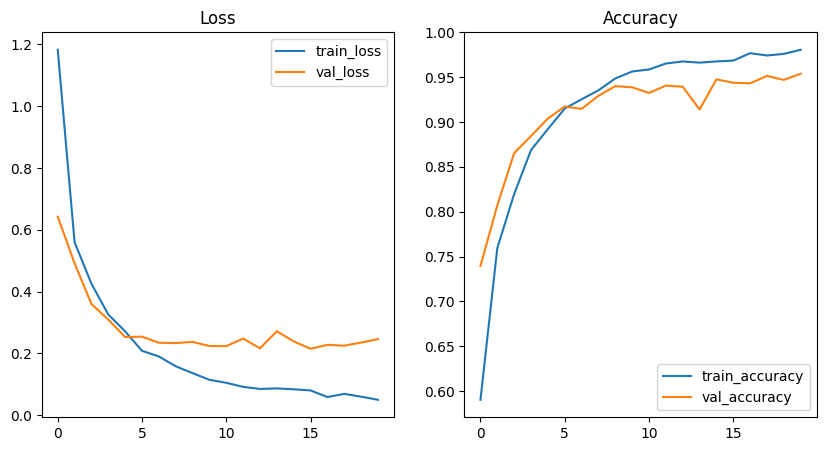

In [ ]:
plot_results([base_cnn_results])

In [ ]:
model_evaluation(base_cnn, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9985 - loss: 0.0058
Train Data, Loss: 0.0066, Accuracy: 0.9978
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9458 - loss: 0.2633
Val Data, Loss: 0.2461, Accuracy: 0.9539


### Base DenseNet Model

In [ ]:
dn_base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_densenet = Sequential()
base_densenet.add(dn_base_model)
base_densenet.add(layers.GlobalAveragePooling2D())
base_densenet.add(layers.Dense(64, activation='relu'))
base_densenet.add(layers.Dropout(0.5))
base_densenet.add(layers.Dense(4, activation='softmax'))

In [ ]:
base_densenet.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
# May take about 10 min to run
base_densenet_results = base_densenet.fit(train_images, train_labels,
                                          epochs=20,
                                          batch_size=100,
                                          validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.7674 - loss: 0.7253 - val_accuracy: 0.6643 - val_loss: 3.1919
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.9453 - loss: 0.1723 - val_accuracy: 0.6365 - val_loss: 4.2835
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.9609 - loss: 0.1211 - val_accuracy: 0.7668 - val_loss: 1.6249
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.9683 - loss: 0.1044 - val_accuracy: 0.9254 - val_loss: 0.2898
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9847 - loss: 0.0532 - val_accuracy: 0.8951 - val_loss: 0.4307
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.9615 - loss: 0.1329 - val_accuracy: 0.8869 - val_loss: 0.4313
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9783 - loss: 0.0725 - val_accuracy: 0.8666 - val_loss: 0.5213
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9784 - loss: 0.0687 - val_accura

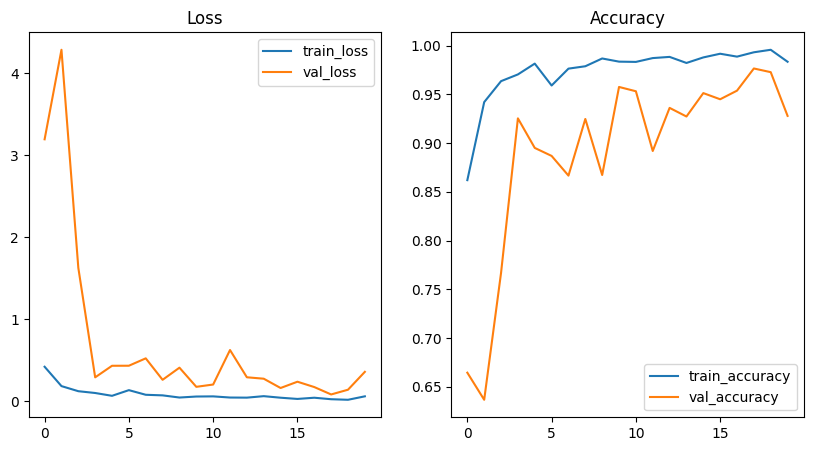

In [ ]:
plot_results([base_densenet_results])

In [ ]:
model_evaluation(base_densenet, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9484 - loss: 0.1941
Train Data, Loss: 0.1888, Accuracy: 0.9486
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.9251 - loss: 0.3850
Val Data, Loss: 0.3568, Accuracy: 0.9279


### Base ResNet Model

In [ ]:
rn_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_resnet = Sequential()
base_resnet.add(rn_base_model)
base_resnet.add(layers.GlobalAveragePooling2D())
base_resnet.add(layers.Dense(64, activation='relu'))
base_resnet.add(layers.Dropout(0.5))
base_resnet.add(layers.Dense(4, activation='softmax'))

In [ ]:
base_resnet.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
base_resnet_results = base_resnet.fit(train_images, train_labels,
                                      epochs=20,
                                      batch_size=100,
                                      validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 128s 808ms/step - accuracy: 0.7575 - loss: 0.6797 - val_accuracy: 0.1662 - val_loss: 49.2125
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9352 - loss: 0.2169 - val_accuracy: 0.3559 - val_loss: 6.7223
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9589 - loss: 0.1461 - val_accuracy: 0.3559 - val_loss: 2.6971
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9742 - loss: 0.0991 - val_accuracy: 0.3597 - val_loss: 2.3552
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9817 - loss: 0.0704 - val_accuracy: 0.3748 - val_loss: 2.1094
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9748 - loss: 0.0879 - val_accuracy: 0.3875 - val_loss: 2.5778
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9862 - loss: 0.0527 - val_accuracy: 0.3559 - val_loss: 4.8873
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9809 - loss: 0.0610 - val_ac

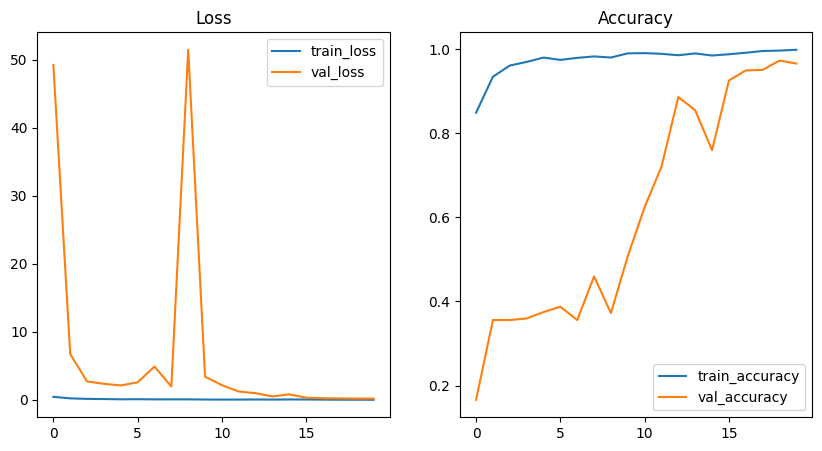

In [ ]:
plot_results([base_resnet_results])

In [ ]:
model_evaluation(base_resnet, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9968 - loss: 0.0100
Train Data, Loss: 0.0119, Accuracy: 0.9961
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9710 - loss: 0.1380
Val Data, Loss: 0.1809, Accuracy: 0.9659


# DenseNet Model

In [ ]:
# Creating early stop callback variable
early_stop = EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5, restore_best_weights=True)

In [ ]:
dn_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [ ]:
# May take up to 10 min to run
dn_model = Sequential()
dn_model.add(dn_base_model)
dn_model.add(layers.GlobalAveragePooling2D())
dn_model.add(layers.Dense(75, activation='relu', kernel_regularizer=l2(l2=0.30)))
dn_model.add(layers.Dropout(0.5))
dn_model.add(layers.Dense(50, activation='relu'))
dn_model.add(layers.Dropout(0.5))
dn_model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(l2=0.30)))
dn_model.add(layers.Dense(4, activation='softmax'))

dn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

dn_model_results = dn_model.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=175,
                                validation_data=(val_images, val_labels),
                                callbacks=[early_stop])

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.6460 - loss: 34.8123 - val_accuracy: 0.9260 - val_loss: 9.2763
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.9473 - loss: 6.7112 - val_accuracy: 0.9703 - val_loss: 2.7611
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.9855 - loss: 2.3797 - val_accuracy: 0.9760 - val_loss: 1.5801
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.9847 - loss: 1.4552 - val_accuracy: 0.9697 - val_loss: 1.0508
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.9899 - loss: 0.9399 - val_accuracy: 0.9829 - val_loss: 0.6839
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - accuracy: 0.9919 - loss: 0.6376 - val_accuracy: 0.9621 - val_loss: 0.5324
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.9801 - loss: 0.4922 - val_accuracy: 0.8793 - val_loss: 0.8003
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.9887 - loss: 0.3468 - val_accur

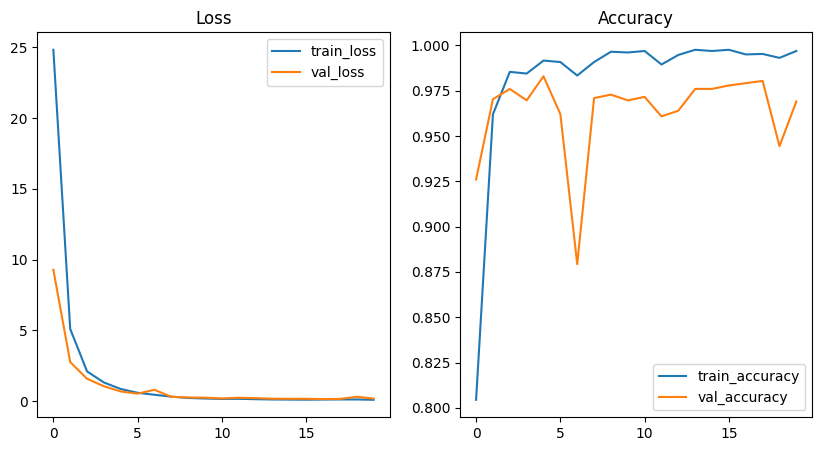

In [ ]:
plot_results([dn_model_results])

In [ ]:
model_evaluation(dn_model, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.9976 - loss: 0.0915
Train Data, Loss: 0.0915, Accuracy: 0.9972
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.9792 - loss: 0.1421
Val Data, Loss: 0.1450, Accuracy: 0.9791


# Evaluation

In [ ]:
final_model = dn_model

final_model.evaluate(test_images, test_labels)

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.9810 - loss: 0.1495


[0.15543712675571442, 0.9811083078384399]

In [ ]:
# Getting test data pedictions
test_img_pred = final_model.predict(test_images)

# Converting test_img_pred and test_labels to single-label format
test_img_pred_labels = np.argmax(test_img_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Classification report
print(classification_report(test_true_labels, test_img_pred_labels))

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       564
           1       0.97      0.98      0.97       352
           2       0.99      1.00      0.99       265
           3       0.97      1.00      0.98       407

    accuracy                           0.98      1588
   macro avg       0.98      0.98      0.98      1588
weighted avg       0.98      0.98      0.98      1588



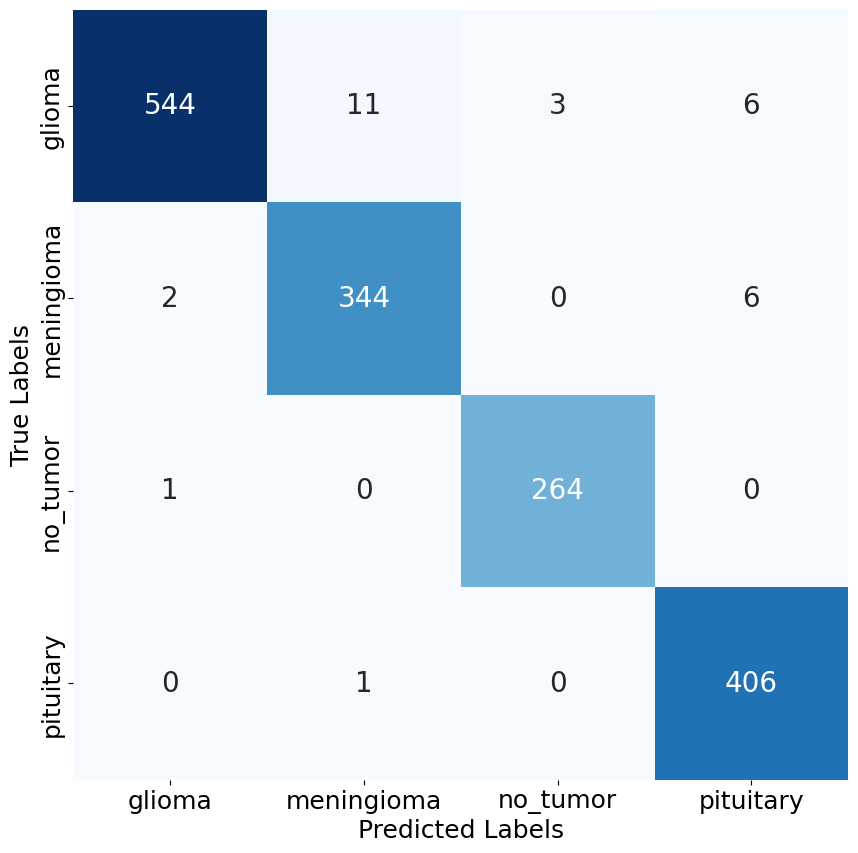

In [ ]:
# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(test_true_labels, test_img_pred_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size' : 20}, cbar=False)

ax.tick_params(axis='both', labelsize=18)
ax.set_yticks([0.5, 1.5, 2.5, 3.5], ['glioma', 'meningioma', 'no_tumor', 'pituitary'])
ax.set_xticks([0.5, 1.5, 2.5, 3.5], ['glioma', 'meningioma', 'no_tumor', 'pituitary'])
ax.set_xlabel('Predicted Labels', fontsize=18)
ax.set_ylabel('True Labels', fontsize=18);

# Limitations

# Next Steps

# Conclusion